In [41]:
import numpy as np
from scipy.fftpack import dct,idct
import matplotlib.pyplot as plt
from matplotlib import rc
import pyfits as pf
%matplotlib inline
rc('text', usetex=True)
plt.rc('font', family='serif')

## Beam decomposition on Zernike polynomials

Questions: jgirard@ska.ac.za

#### 0) Loading fits

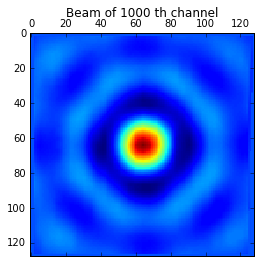

In [2]:
beam="shiftedscaled_ant5LLreal.fits"
d=pf.getdata(beam)
sliceidx=1000
plt.matshow(d[sliceidx,:,:])
plt.title("Beam of %s th channel"%sliceidx)
sliceb=d[sliceidx,:,:]
nx,ny=sliceb.shape

#### 1) Zernike help functions

In [3]:
from scipy.misc import factorial as fac
### Init functions
def zernike_rad(m, n, rho):
	"""
	Calculate the radial component of Zernike polynomial (m, n) 
	given a grid of radial coordinates rho.
	
	>>> zernike_rad(3, 3, 0.333)
	0.036926037000000009
	>>> zernike_rad(1, 3, 0.333)
	-0.55522188900000002
	>>> zernike_rad(3, 5, 0.12345)
	-0.007382104685237683
	"""
	
	if (n < 0 or m < 0 or abs(m) > n):
		raise ValueError
	
	if ((n-m) % 2):
		return rho*0.0
	
	pre_fac = lambda k: (-1.0)**k * fac(n-k) / ( fac(k) * fac( (n+m)/2.0 - k ) * fac( (n-m)/2.0 - k ) )
	
	return sum(pre_fac(k) * rho**(n-2.0*k) for k in xrange((n-m)/2+1))

def zernike(m, n, rho, phi):
	"""
	Calculate Zernike polynomial (m, n) given a grid of radial
	coordinates rho and azimuthal coordinates phi.
	
	>>> zernike(3,5, 0.12345, 1.0)
	0.0073082282475042991
	>>> zernike(1, 3, 0.333, 5.0)
	-0.15749545445076085
	"""
	if (m > 0): return zernike_rad(m, n, rho) * np.cos(m * phi)
	if (m < 0): return zernike_rad(-m, n, rho) * np.sin(-m * phi)
	return zernike_rad(0, n, rho)

def zernikel(j, rho, phi):
	"""
	Calculate Zernike polynomial with Noll coordinate j given a grid of radial
	coordinates rho and azimuthal coordinates phi.
	
	>>> zernikel(0, 0.12345, 0.231)
	1.0
	>>> zernikel(1, 0.12345, 0.231)
	0.028264010304937772
	>>> zernikel(6, 0.12345, 0.231)
	0.0012019069816780774
	"""
	n = 0
	while (j > n):
		n += 1
		j -= n
	
	m = -n+2*j
	return zernike(m, n, rho, phi)

#### 2) Creating ($\rho$,$\phi$) grids and masking grid

In [4]:
grid = (np.indices((nx, nx), dtype=np.float) - nx/2) / (nx*1./2)
grid_rho = (grid**2.0).sum(0)**0.5
grid_phi = np.arctan2(grid[0], grid[1])
grid_mask = grid_rho <= 1
grid_mask.shape

(128, 128)

#### 3) Creating the Zernike basis to the Nth order and plotting orthogonality

The problem to solve is $\mathbf{A} x = b$ (1)

with $\mathbf{A}$, the zernike basis, $x$ the coefficients and $b$ the observed beam.

The coefficients $x$ are obtained by solving (1) using a Moore-Penrose pseudoinverse:

 $ x = \mathbf{A}^{PI} b= (\mathbf{A}^{T} \mathbf{A})^{-1} \mathbf{A}^{T} b$
 
 We compute $\mathbf{A}^{T} \mathbf{A}$ with the covariance matrix $\mathbf{A}$ and the pseudo inverse using a SVD.

In [5]:
N=100
basis=[zernikel(i, grid_rho, grid_phi)*grid_mask for i in range(N)]

In [6]:
# Calculate covariance between all Zernike polynomials
cov_mat = np.array([[np.sum(zerni * zernj) for zerni in basis] for zernj in basis])

# Invert covariance matrix using SVD (  A x = b  ==>  x =>  x= A^{pseudoinv} b)
cov_mat_in = np.linalg.pinv(cov_mat)


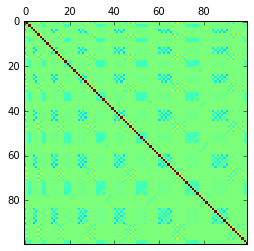

In [7]:
# almost orthogonal (numerical errors?)
plt.matshow(cov_mat,vmin=-50,vmax=50)

#### 4) Computing beam coefficients in the Zernike basis to the Nth order and truncating

innerprod == $\mathbf{A}b$

coefficients == $(\mathbf{A}^T \mathbf{A})^{-1} \mathbf{A}^{T} b$ == $x$

In [8]:
innerprod = np.array([np.sum(sliceb * zerni) for zerni in basis])

# Given the inner product vector of the input image with Zernike basis,
# calculate the Zernike polynomial coefficients
# (A^T A)^(-1) A^T b = x
# innerprod === A^T b
# coefficients == (A^T A)^(-1)
coefficients = np.dot(cov_mat_in, innerprod)

##### Sorted by decomposition order

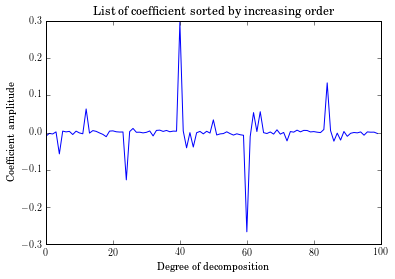

In [154]:
plt.plot(coefficients)
plt.title('List of coefficient sorted by increasing order')
plt.xlabel('Degree of decomposition')
plt.ylabel('Coefficient amplitude')
plt.savefig('Zernike-coefficients-byorder.pdf',bbox_inches='tight', pad_inches=0)


##### Sorted by decreasing energy

In [155]:
sortedindex=np.argsort(np.abs(coefficients))[::-1]
Ncoeff=coefficients.shape[-1]
zernnumb=0.10 # % of coefficients sorted in decreasing energy
cutoff=np.int(np.round(Ncoeff*zernnumb))

print "Keeping %2.2f %% (N=%s) of the biggest coefficients"%(100.*zernnumb,cutoff)
coefficients_trunc=coefficients.copy() # copy of all coeff
coefficients_trunc[sortedindex[cutoff:]]=0 # put coeff below threshold to 0


Keeping 10.00 % (N=10) of the biggest coefficients


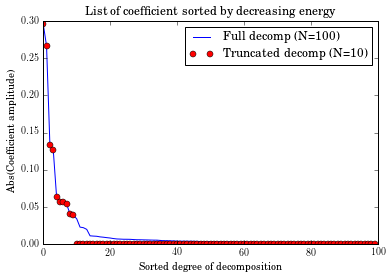

In [156]:
plt.plot(np.abs(coefficients[sortedindex]),label="Full decomp (N=%s)"%N)
plt.plot(np.abs(coefficients_trunc[sortedindex]),"ro",label="Truncated decomp (N=%s)"%cutoff)
plt.legend()
plt.title('List of coefficient sorted by decreasing energy')
plt.xlabel('Sorted degree of decomposition')
plt.ylabel('Abs(Coefficient amplitude)')
plt.savefig('Zernike-coefficients-bypower.pdf',bbox_inches='tight', pad_inches=0)


In [161]:
# reconstructions
approx_full = np.sum(val * zernikel(i, grid_rho, grid_phi)*grid_mask for (i, val) in enumerate(coefficients))
approx_trunc = np.sum(val * zernikel(i, grid_rho, grid_phi)*grid_mask for (i, val) in enumerate(coefficients_trunc))

Mmax=np.max([np.max(sliceb),np.max(approx_full),np.max(approx_trunc)])
mmin=np.min([np.min(sliceb),np.min(approx_full),np.min(approx_trunc)])

# differences

diffdatafull=(sliceb-approx_full)*grid_mask
diffdatatrunc=(sliceb-approx_trunc)*grid_mask
difffulltrunc=(approx_full-approx_trunc)*grid_mask

Mmaxdiff=np.max([np.max(diffdatafull),np.max(diffdatatrunc),np.max(difffulltrunc)])
mmindiff=np.min([np.min(diffdatafull),np.min(diffdatatrunc),np.min(difffulltrunc)])

#### 5) Reconstructing the beam using the full decomposition or truncated decomposition

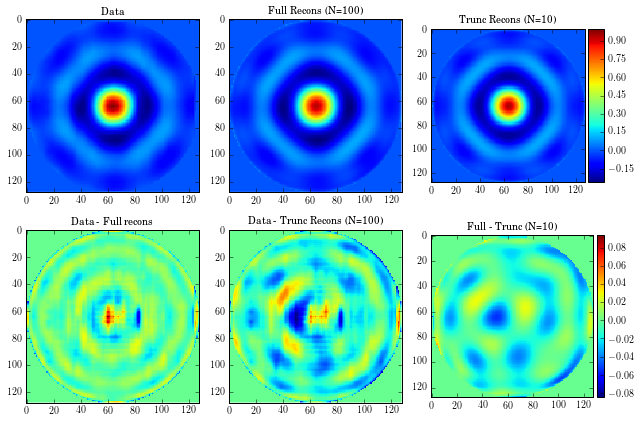

In [162]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax=plt.subplots(nrows=2, ncols=3,figsize=(9,6))
ax[0,0].imshow(sliceb*grid_mask,interpolation="None",vmax=Mmax,vmin=mmin)
ax[0,0].set_title(r'Data',fontsize=10)
#cbar = fig.colorbar(cax,fraction=0.046, pad=0.04)

#cbar=plt.colorbar()
#cbar.set_label(r"AU", size=10)
#cbar.ax.tick_params(labelsize=10)

ax[0,1].imshow(approx_full,interpolation="None",vmax=Mmax,vmin=mmin)
#cbar.set_label(r"AU", size=10)
ax[0,1].set_title(r'Full Recons (N=%s)'%N,fontsize=10)

im=ax[0,2].imshow(approx_trunc,interpolation="None",vmax=Mmax,vmin=mmin,aspect='equal')
ax[0,2].set_title(r'Trunc Recons (N=%s)'%cutoff,fontsize=10)
divider = make_axes_locatable(ax[0,2])
cax=divider.append_axes("right", size = "10.6%", pad = 0.04)
plt.colorbar(im, cax = cax)

#cbar=fig.colorbar(cax,fraction=0.046, pad=0.04)
#cbar=plt.colorbar()
#cbar.set_label(r"AU", size=10)
#cbar.ax.tick_params(labelsize=10)

ax[1,0].imshow(diffdatafull,interpolation="None",vmax=Mmaxdiff,vmin=mmindiff)
ax[1,0].set_title(r'Data - Full recons',fontsize=10)

ax[1,1].imshow(diffdatatrunc,interpolation="None",vmax=Mmaxdiff,vmin=mmindiff)
ax[1,1].set_title(r'Data - Trunc Recons (N=%s)'%N,fontsize=10)

im2=ax[1,2].imshow(difffulltrunc,interpolation="None",vmax=Mmaxdiff,vmin=mmindiff,aspect='equal')
ax[1,2].set_title(r'Full - Trunc (N=%s)'%cutoff,fontsize=10)
divider = make_axes_locatable(ax[1,2])
cax=divider.append_axes("right", size = "4.6%", pad = 0.05)
plt.colorbar(im2, cax = cax)

#cbar=plt.colorbar()
#cbar.set_label(r"AU", size=10)
#cbar.ax.tick_params(labelsize=10) 
plt.tight_layout()

#### Pretty figure

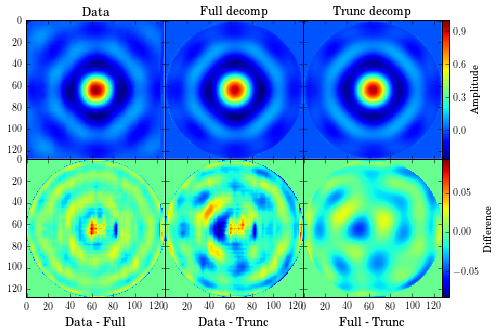

In [166]:
from mpl_toolkits.axes_grid1 import AxesGrid

F = plt.figure(1, figsize=(30,20))

F.subplots_adjust(left=0.05, right=0.95)

grid = AxesGrid(F, 142,  # similar to subplot(142)
                    nrows_ncols=(2, 3),
                    axes_pad=0.0,
                    share_all=True,
                    label_mode="L",
                    cbar_location="right",
                    cbar_mode="edge",
                    )

Z=[sliceb,approx_full,approx_trunc,diffdatafull,diffdatatrunc,difffulltrunc]
titles=['Data','Full decomp','Trunc decomp']
subtitles=['Data - Full','Data - Trunc','Full - Trunc']
for i in range(6):
    if i < 3:
        im = grid[i].imshow(Z[i], interpolation="None",vmin=mmin,vmax=Mmax)
        grid[i].set_title(titles[i],fontsize=12)
        
    if i >= 3:
        im2= grid[i].imshow(Z[i], interpolation="None",vmin=mmindiff,vmax=Mmaxdiff)
        grid[i].set_xlabel(subtitles[i-3],fontsize=12)
    #plt.colorbar(im, cax = grid.cbar_axes[0])
    grid.cbar_axes[0].colorbar(im)
    grid.cbar_axes[0].set_ylabel("Amplitude") 
    grid.cbar_axes[1].colorbar(im2)
    grid.cbar_axes[1].set_ylabel("Difference") 

    plt.savefig('Zernike-comparison.pdf',bbox_inches='tight', pad_inches=0.2)
    #for cax in grid.cbar_axes:
    #    cax.toggle_label(False)

    # This affects all axes as share_all = True.
    #grid.axes_llc.set_xticks([-2, 0, 2])
    #grid.axes_llc.set_yticks([-2, 0, 2])